In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import sys
sys.path.append('../')
from solar_prediction.data_loader import load_solar_dataset, get_dataset_info
import solar_prediction.lstm as lstm #
from solar_prediction.lstm import ModelHyperparameters, TrainingConfig # Import the dataclasses
from solar_prediction.data_prep import (
    DataInputConfig,
    TransformationConfig,
    FeatureEngineeringConfig,
    ScalingConfig,
    SequenceConfig,
    prepare_weather_data
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Load dataset with automatic fallback to sample data


# Check available datasets
dataset_info = get_dataset_info()
print('Available datasets:')
for name, info in dataset_info.items():
    if info['exists']:
        print(f'  {name}: {info["records"]} records ({info["size_mb"]} MB)')
    else:
        print(f'  {name}: Not found')

# Load the dataset (will use full dataset if available, otherwise sample)
df = load_solar_dataset()
print(f'\nLoaded dataset with {len(df)} records')
df

2025-07-03 21:06:42,830 - INFO - Loading full dataset from: /Users/tom/workspace/github.com/itxtx/solar_prediction/notebooks/../data/solar_weather.csv
2025-07-03 21:06:42,969 - INFO - Successfully loaded full dataset with 196776 records


Available datasets:
  full_dataset: 196776 records (14.22 MB)
  sample_dataset: 1856 records (0.16 MB)

Loaded dataset with 196776 records


,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


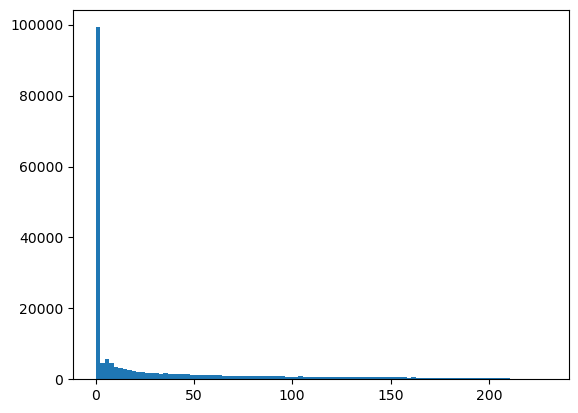

In [3]:
rad = df['GHI']

plt.hist(rad, bins=100)
plt.show()




## LSTM NN

In [4]:
target_col_original = 'GHI' 

input_cfg = DataInputConfig(
    target_col_original_name=target_col_original
)

transform_cfg = TransformationConfig(
    use_log_transform=False, 
    use_power_transform=True, 
    use_piecewise_transform_target=False, 
    min_target_threshold_initial=None, 
    clip_original_target_before_power_transform=False, 
    original_target_clip_lower_percentile=10.0, 
    original_target_clip_upper_percentile=90.0, 
    min_radiation_floor_before_power_transform=0.0, 
    min_radiation_for_log=0.001, 
    clip_log_transformed_target=True, 
    log_clip_lower_percentile=1.0, 
    log_clip_upper_percentile=99.0 
)

feature_cfg = FeatureEngineeringConfig(
    use_solar_elevation_proxy=True, 
    feature_selection_mode='basic' 
   
)

scaling_cfg = ScalingConfig(
    standardize_features=False 
)

sequence_cfg = SequenceConfig(
    window_size=24, 
    test_size=0.15, 
    val_size_from_train_val=0.25 / (1.0 - 0.15) if (1.0 - 0.15) > 0 else 0.25
)


In [5]:
try:
    X_train, X_val, X_test, y_train, y_val, y_test, \
    scalers, feature_cols, full_transform_details = prepare_weather_data(
        df_input=df,
        input_cfg=input_cfg,
        transform_cfg=transform_cfg,
        feature_cfg=feature_cfg,
        scaling_cfg=scaling_cfg,
        sequence_cfg=sequence_cfg
    )

    logging.info("Data preparation successful using v2.")
    logging.info(f"X_train shape: {X_train.shape}, feature_cols: {feature_cols}")
    logging.info(f"Full transform details: {full_transform_details}")

except Exception as e:
    logging.error(f"Error during data preparation: {e}", exc_info=True)

2025-07-03 21:06:48,114 - INFO - Starting weather data preparation pipeline v2.
2025-07-03 21:06:48,120 - INFO - Applied column renames: {'GHI': 'Radiation', 'temp': 'Temperature', 'pressure': 'Pressure', 'humidity': 'Humidity', 'wind_speed': 'WindSpeed', 'clouds_all': 'Cloudcover', 'rain_1h': 'Rain', 'snow_1h': 'Snow', 'weather_type': 'WeatherType', 'Time': 'Timestamp', 'hour': 'hour', 'month': 'month', 'dayLength': 'dayLength', 'isSun': 'isSun', 'SunlightTime/daylength': 'SunlightTime/daylength'}
2025-07-03 21:06:48,164 - INFO - Sorted DataFrame by 'Timestamp'.
2025-07-03 21:06:48,255 - INFO - Engineered 'SolarElevation' feature.
2025-07-03 21:06:48,274 - INFO - Applying Yeo-Johnson Power Transform to 'Radiation'.
2025-07-03 21:06:48,351 - INFO - Engineered 'Radiation_is_low' feature with threshold -0.0000 (based on 'Radiation_yj').
2025-07-03 21:06:48,351 - INFO - Including low target indicator 'Radiation_is_low' in features.
2025-07-03 21:06:48,352 - INFO - Final selected features 

In [6]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    
    # Create model hyperparameters
    model_params = ModelHyperparameters(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Create training config
    train_cfg = TrainingConfig(
        epochs=10,  # Just 10 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,
        clip_grad_norm=clip_grad_norm,
        T_max_cosine=10
    )
    
    # Create and train model
    model = lstm.WeatherLSTM(model_params)
    model.fit(
        X_train, y_train, X_val, y_val,
        train_cfg
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-06-06 20:35:03,522] A new study created in memory with name: no-name-734038ae-a643-4b1e-9c43-9ceecc21fb93
2025-06-06 20:35:03,546 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.00024349917184249064, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.0, scheduler_type='plateau', T_max_cosine=10, loss_type='mse', mse_weight=0.9, mape_weight=0.3, value_multiplier=0.2)
2025-06-06 20:35:03,546 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0003882577099676562, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.5, scheduler_type='plateau', T_max_cosine=10, loss_type='mse', mse_weight=0.5, mape_weight=0.1, value_multiplier=0.1)
2025-06-06 20:35:03,547 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.00013575501932431436, pati

Trial 11: hidden_dim=64, num_layers=1, dropout_prob=0.3, learning_rate=0.000388, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9818


2025-06-06 20:46:09,549 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0460 - ValLoss: 0.0286 | Scaled Metrics: ValRMSE: 0.1690, ValR²: 0.9719, ValCappedMAPE: 14.05%, ValMAE: 0.1184
2025-06-06 20:46:18,019 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0286 - ValLoss: 0.0150 | Scaled Metrics: ValRMSE: 0.1226, ValR²: 0.9852, ValCappedMAPE: 10.53%, ValMAE: 0.0663
2025-06-06 20:46:18,316 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0573 - ValLoss: 0.0450 | Scaled Metrics: ValRMSE: 0.2121, ValR²: 0.9557, ValCappedMAPE: 14.55%, ValMAE: 0.1180
2025-06-06 20:47:46,325 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0447 - ValLoss: 0.0251 | Scaled Metrics: ValRMSE: 0.1585, ValR²: 0.9753, ValCappedMAPE: 13.42%, ValMAE: 0.1092
2025-06-06 20:49:19,684 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0546 - ValLoss: 0.0290 | Scaled Metrics: ValRMSE: 0.1703, ValR²: 0.9714, ValCappedMAPE: 14.12%, ValMAE: 0.0984
2025-06-06 20:49:30,022 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1124 - ValLoss: 0.0549 | Scaled Metrics: ValRMSE: 0.1587, Val

Trial 2: hidden_dim=64, num_layers=2, dropout_prob=0.3, learning_rate=0.000776, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9764


2025-06-06 20:59:06,196 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0379 - ValLoss: 0.0215 | Scaled Metrics: ValRMSE: 0.1465, ValR²: 0.9789, ValCappedMAPE: 10.83%, ValMAE: 0.0684
2025-06-06 20:59:53,377 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.0843 - ValLoss: 0.0271 | Scaled Metrics: ValRMSE: 0.1646, ValR²: 0.9733, ValCappedMAPE: 14.79%, ValMAE: 0.1049
2025-06-06 21:00:26,383 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0180 - ValLoss: 0.0126 | Scaled Metrics: ValRMSE: 0.1123, ValR²: 0.9876, ValCappedMAPE: 9.40%, ValMAE: 0.0587
2025-06-06 21:00:28,605 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0351 - ValLoss: 0.0174 | Scaled Metrics: ValRMSE: 0.1318, ValR²: 0.9829, ValCappedMAPE: 12.20%, ValMAE: 0.0865
2025-06-06 21:01:49,531 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1538 - ValLoss: 0.0751 | Scaled Metrics: ValRMSE: 0.1735, ValR²: 0.9704, ValCappedMAPE: 11.81%, ValMAE: 0.0857
2025-06-06 21:02:50,227 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0200 - ValLoss: 0.0137 | Scaled Metrics: ValRMSE: 0.1169, ValR

Trial 10: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000348, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9888


2025-06-06 21:52:11,182 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0288 - ValLoss: 0.0160 | Scaled Metrics: ValRMSE: 0.1263, ValR²: 0.9843, ValCappedMAPE: 12.04%, ValMAE: 0.0856
2025-06-06 21:52:11,183 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 21:52:13,874] Trial 0 finished with value: 0.9842811608384253 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.3, 'learning_rate': 0.00024349917184249064, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 10 with value: 0.988839146416874.
2025-06-06 21:52:13,878 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0004957870893233277, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.5, scheduler_type='cosine', T_max_cosine=10, loss_type='value_aware', mse_weight=0.7, mape_weight=0.3, value_multiplier=0.1)


Trial 0: hidden_dim=128, num_layers=1, dropout_prob=0.3, learning_rate=0.000243, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9843


2025-06-06 21:53:43,957 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0229 - ValLoss: 0.0120 | Scaled Metrics: ValRMSE: 0.1097, ValR²: 0.9881, ValCappedMAPE: 9.79%, ValMAE: 0.0560
2025-06-06 21:53:46,907 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0654 - ValLoss: 0.0554 | Scaled Metrics: ValRMSE: 0.1276, ValR²: 0.9840, ValCappedMAPE: 9.32%, ValMAE: 0.0650
2025-06-06 21:55:12,239 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0306 - ValLoss: 0.0282 | Scaled Metrics: ValRMSE: 0.1330, ValR²: 0.9826, ValCappedMAPE: 11.13%, ValMAE: 0.0828
2025-06-06 21:55:16,756 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0444 - ValLoss: 0.0472 | Scaled Metrics: ValRMSE: 0.1282, ValR²: 0.9838, ValCappedMAPE: 11.53%, ValMAE: 0.0818
2025-06-06 21:57:41,609 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0130 - ValLoss: 0.0122 | Scaled Metrics: ValRMSE: 0.1104, ValR²: 0.9880, ValCappedMAPE: 8.54%, ValMAE: 0.0507
2025-06-06 22:00:15,218 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1425 - ValLoss: 0.0620 | Scaled Metrics: ValRMSE: 0.1842, ValR²:

Trial 5: hidden_dim=256, num_layers=1, dropout_prob=0.3, learning_rate=0.000136, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9870


2025-06-06 22:16:31,791 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0293 - ValLoss: 0.0253 | Scaled Metrics: ValRMSE: 0.1199, ValR²: 0.9858, ValCappedMAPE: 11.39%, ValMAE: 0.0796
2025-06-06 22:16:38,415 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0428 - ValLoss: 0.0429 | Scaled Metrics: ValRMSE: 0.1345, ValR²: 0.9822, ValCappedMAPE: 9.72%, ValMAE: 0.0700
2025-06-06 22:17:10,304 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0652 - ValLoss: 0.0377 | Scaled Metrics: ValRMSE: 0.1108, ValR²: 0.9879, ValCappedMAPE: 9.56%, ValMAE: 0.0564
2025-06-06 22:18:31,014 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0636 - ValLoss: 0.0512 | Scaled Metrics: ValRMSE: 0.1124, ValR²: 0.9876, ValCappedMAPE: 8.86%, ValMAE: 0.0588
2025-06-06 22:18:31,015 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 22:18:33,312] Trial 13 finished with value: 0.9875549185729872 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.0006251860874751143, 'clip_grad_norm': 1.0, 'value

Trial 13: hidden_dim=128, num_layers=1, dropout_prob=0.1, learning_rate=0.000625, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9876


2025-06-06 22:18:43,821 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0118 - ValLoss: 0.0096 | Scaled Metrics: ValRMSE: 0.0980, ValR²: 0.9905, ValCappedMAPE: 8.40%, ValMAE: 0.0470
2025-06-06 22:25:06,228 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0625 - ValLoss: 0.0454 | Scaled Metrics: ValRMSE: 0.1384, ValR²: 0.9811, ValCappedMAPE: 10.38%, ValMAE: 0.0752
2025-06-06 22:28:59,768 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0116 - ValLoss: 0.0095 | Scaled Metrics: ValRMSE: 0.0977, ValR²: 0.9906, ValCappedMAPE: 8.34%, ValMAE: 0.0468
2025-06-06 22:28:59,770 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 22:29:08,641] Trial 12 finished with value: 0.9906067254009002 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00038681407087125133, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9906067254009002.
2025-06-06 22:29:

Trial 12: hidden_dim=256, num_layers=1, dropout_prob=0.1, learning_rate=0.000387, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9906


2025-06-06 22:32:13,485 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.0933 - ValLoss: 0.0381 | Scaled Metrics: ValRMSE: 0.1951, ValR²: 0.9625, ValCappedMAPE: 15.24%, ValMAE: 0.1286
2025-06-06 22:32:58,465 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0605 - ValLoss: 0.0471 | Scaled Metrics: ValRMSE: 0.1316, ValR²: 0.9829, ValCappedMAPE: 11.34%, ValMAE: 0.0839
2025-06-06 22:34:17,009 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0352 - ValLoss: 0.0272 | Scaled Metrics: ValRMSE: 0.1703, ValR²: 0.9714, ValCappedMAPE: 11.20%, ValMAE: 0.0857
2025-06-06 22:35:20,755 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0390 - ValLoss: 0.0206 | Scaled Metrics: ValRMSE: 0.1435, ValR²: 0.9797, ValCappedMAPE: 12.12%, ValMAE: 0.0902
2025-06-06 22:36:46,914 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0710 - ValLoss: 0.0580 | Scaled Metrics: ValRMSE: 0.1230, ValR²: 0.9851, ValCappedMAPE: 10.00%, ValMAE: 0.0692
2025-06-06 22:36:51,298 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0342 - ValLoss: 0.0230 | Scaled Metrics: ValRMSE: 0.1518, Val

Trial 18: hidden_dim=64, num_layers=3, dropout_prob=0.2, learning_rate=0.000907, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9829


2025-06-06 22:58:57,602 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0564 - ValLoss: 0.0394 | Scaled Metrics: ValRMSE: 0.1170, ValR²: 0.9865, ValCappedMAPE: 9.75%, ValMAE: 0.0677
2025-06-06 23:01:45,805 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0145 - ValLoss: 0.0152 | Scaled Metrics: ValRMSE: 0.1235, ValR²: 0.9850, ValCappedMAPE: 9.54%, ValMAE: 0.0652
2025-06-06 23:05:07,687 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0560 - ValLoss: 0.0390 | Scaled Metrics: ValRMSE: 0.1159, ValR²: 0.9868, ValCappedMAPE: 9.64%, ValMAE: 0.0667
2025-06-06 23:05:07,690 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 23:05:13,839] Trial 15 finished with value: 0.9867653498361516 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout_prob': 0.2, 'learning_rate': 0.0004957870893233277, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9906067254009002.


Trial 15: hidden_dim=128, num_layers=1, dropout_prob=0.2, learning_rate=0.000496, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9868


2025-06-06 23:07:08,672 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0286 - ValLoss: 0.0192 | Scaled Metrics: ValRMSE: 0.1311, ValR²: 0.9831, ValCappedMAPE: 9.67%, ValMAE: 0.0667
2025-06-06 23:08:04,162 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0286 - ValLoss: 0.0254 | Scaled Metrics: ValRMSE: 0.1593, ValR²: 0.9750, ValCappedMAPE: 13.31%, ValMAE: 0.1069
2025-06-06 23:09:14,711 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0261 - ValLoss: 0.0229 | Scaled Metrics: ValRMSE: 0.1141, ValR²: 0.9872, ValCappedMAPE: 10.33%, ValMAE: 0.0740
2025-06-06 23:09:15,718 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0392 - ValLoss: 0.0359 | Scaled Metrics: ValRMSE: 0.1126, ValR²: 0.9875, ValCappedMAPE: 8.74%, ValMAE: 0.0590
2025-06-06 23:10:49,339 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0245 - ValLoss: 0.0248 | Scaled Metrics: ValRMSE: 0.1573, ValR²: 0.9756, ValCappedMAPE: 12.29%, ValMAE: 0.0955
2025-06-06 23:13:50,937 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1228 - ValLoss: 0.0637 | Scaled Metrics: ValRMSE: 0.2521, ValR²

Trial 4: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000733, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9874


[I 2025-06-06 23:39:13,499] Trial 9 finished with value: 0.9889026940290051 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.00039308409041530966, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9906067254009002.


Trial 9: hidden_dim=256, num_layers=2, dropout_prob=0.1, learning_rate=0.000393, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9889


2025-06-06 23:41:26,017 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0437 - ValLoss: 0.0285 | Scaled Metrics: ValRMSE: 0.1487, ValR²: 0.9782, ValCappedMAPE: 12.16%, ValMAE: 0.0817
2025-06-06 23:43:29,691 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0127 - ValLoss: 0.0120 | Scaled Metrics: ValRMSE: 0.1096, ValR²: 0.9882, ValCappedMAPE: 9.60%, ValMAE: 0.0624
2025-06-06 23:44:44,320 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0649 - ValLoss: 0.0582 | Scaled Metrics: ValRMSE: 0.1280, ValR²: 0.9839, ValCappedMAPE: 9.89%, ValMAE: 0.0733
2025-06-06 23:44:45,807 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0297 - ValLoss: 0.0176 | Scaled Metrics: ValRMSE: 0.1326, ValR²: 0.9827, ValCappedMAPE: 11.36%, ValMAE: 0.0821
2025-06-06 23:44:50,361 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0681 - ValLoss: 0.0591 | Scaled Metrics: ValRMSE: 0.1225, ValR²: 0.9852, ValCappedMAPE: 9.46%, ValMAE: 0.0672
2025-06-06 23:44:54,465 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0131 - ValLoss: 0.0109 | Scaled Metrics: ValRMSE: 0.1044, ValR²:

Trial 3: hidden_dim=128, num_layers=3, dropout_prob=0.3, learning_rate=0.000221, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9834


[I 2025-06-06 23:54:25,126] Trial 1 finished with value: 0.9846352891822358 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00022033000855087238, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 12 with value: 0.9906067254009002.


Trial 1: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000220, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9846


2025-06-06 23:54:26,776 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0675 - ValLoss: 0.0583 | Scaled Metrics: ValRMSE: 0.1209, ValR²: 0.9856, ValCappedMAPE: 9.35%, ValMAE: 0.0659
2025-06-06 23:54:26,777 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 23:54:31,170] Trial 6 finished with value: 0.9855969009728632 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0002564923373227168, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.5}. Best is trial 12 with value: 0.9906067254009002.
2025-06-06 23:54:31,302 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0128 - ValLoss: 0.0111 | Scaled Metrics: ValRMSE: 0.1056, ValR²: 0.9890, ValCappedMAPE: 9.43%, ValMAE: 0.0619
2025-06-06 23:54:31,303 - INFO - LSTM Training complete. Best model state loaded.


Trial 6: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000256, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9856


[I 2025-06-06 23:54:35,610] Trial 7 finished with value: 0.9890272152543487 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.0004572706151622551, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.7, 'mape_weight': 0.1}. Best is trial 12 with value: 0.9906067254009002.


Trial 7: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000457, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9890


2025-06-06 23:54:45,558 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0249 - ValLoss: 0.0163 | Scaled Metrics: ValRMSE: 0.1139, ValR²: 0.9872, ValCappedMAPE: 9.17%, ValMAE: 0.0603
2025-06-06 23:55:44,030 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0123 - ValLoss: 0.0106 | Scaled Metrics: ValRMSE: 0.1031, ValR²: 0.9895, ValCappedMAPE: 9.40%, ValMAE: 0.0598
2025-06-06 23:56:48,399 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0316 - ValLoss: 0.0254 | Scaled Metrics: ValRMSE: 0.1396, ValR²: 0.9808, ValCappedMAPE: 10.91%, ValMAE: 0.0791
2025-06-06 23:57:36,276 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0181 - ValLoss: 0.0196 | Scaled Metrics: ValRMSE: 0.1400, ValR²: 0.9807, ValCappedMAPE: 11.42%, ValMAE: 0.0879
2025-06-06 23:58:25,677 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0192 - ValLoss: 0.0170 | Scaled Metrics: ValRMSE: 0.1303, ValR²: 0.9833, ValCappedMAPE: 11.13%, ValMAE: 0.0819
2025-06-06 23:59:21,970 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0246 - ValLoss: 0.0171 | Scaled Metrics: ValRMSE: 0.1144, ValR²

Trial 14: hidden_dim=256, num_layers=2, dropout_prob=0.3, learning_rate=0.000347, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9878


2025-06-07 00:05:00,895 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0169 - ValLoss: 0.0190 | Scaled Metrics: ValRMSE: 0.1379, ValR²: 0.9813, ValCappedMAPE: 11.66%, ValMAE: 0.0873
2025-06-07 00:05:40,949 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0187 - ValLoss: 0.0155 | Scaled Metrics: ValRMSE: 0.1246, ValR²: 0.9847, ValCappedMAPE: 10.65%, ValMAE: 0.0723
2025-06-07 00:06:08,691 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0281 - ValLoss: 0.0225 | Scaled Metrics: ValRMSE: 0.1282, ValR²: 0.9838, ValCappedMAPE: 10.20%, ValMAE: 0.0729
2025-06-07 00:09:24,108 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0114 - ValLoss: 0.0110 | Scaled Metrics: ValRMSE: 0.1047, ValR²: 0.9892, ValCappedMAPE: 9.15%, ValMAE: 0.0580
2025-06-07 00:09:24,109 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-07 00:09:46,454] Trial 8 finished with value: 0.9892125170161971 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00024657133800166594, 'clip_grad_norm': 1.0, 'val

Trial 8: hidden_dim=256, num_layers=3, dropout_prob=0.1, learning_rate=0.000247, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9892


2025-06-07 00:10:12,478 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0271 - ValLoss: 0.0237 | Scaled Metrics: ValRMSE: 0.1331, ValR²: 0.9826, ValCappedMAPE: 10.48%, ValMAE: 0.0758
2025-06-07 00:10:48,506 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0160 - ValLoss: 0.0157 | Scaled Metrics: ValRMSE: 0.1253, ValR²: 0.9845, ValCappedMAPE: 10.64%, ValMAE: 0.0773
2025-06-07 00:11:21,465 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0182 - ValLoss: 0.0131 | Scaled Metrics: ValRMSE: 0.1144, ValR²: 0.9871, ValCappedMAPE: 10.47%, ValMAE: 0.0717
2025-06-07 00:13:21,426 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0265 - ValLoss: 0.0234 | Scaled Metrics: ValRMSE: 0.1322, ValR²: 0.9828, ValCappedMAPE: 10.33%, ValMAE: 0.0748
2025-06-07 00:15:39,216 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0152 - ValLoss: 0.0154 | Scaled Metrics: ValRMSE: 0.1239, ValR²: 0.9849, ValCappedMAPE: 10.80%, ValMAE: 0.0784
2025-06-07 00:16:13,009 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0182 - ValLoss: 0.0128 | Scaled Metrics: ValRMSE: 0.1133, Val

Trial 19: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000111, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9809


2025-06-07 00:19:40,514 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0146 - ValLoss: 0.0143 | Scaled Metrics: ValRMSE: 0.1196, ValR²: 0.9859, ValCappedMAPE: 10.51%, ValMAE: 0.0742
2025-06-07 00:20:06,403 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0180 - ValLoss: 0.0138 | Scaled Metrics: ValRMSE: 0.1174, ValR²: 0.9864, ValCappedMAPE: 10.45%, ValMAE: 0.0740
2025-06-07 00:23:18,906 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0143 - ValLoss: 0.0144 | Scaled Metrics: ValRMSE: 0.1198, ValR²: 0.9859, ValCappedMAPE: 10.43%, ValMAE: 0.0745
2025-06-07 00:23:18,908 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-07 00:23:38,028] Trial 16 finished with value: 0.9858589320513597 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.00031513712203246427, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 12 with value: 0.9906067254009002.


Trial 16: hidden_dim=256, num_layers=3, dropout_prob=0.2, learning_rate=0.000315, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9859


2025-06-07 00:23:52,029 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0176 - ValLoss: 0.0114 | Scaled Metrics: ValRMSE: 0.1066, ValR²: 0.9888, ValCappedMAPE: 10.17%, ValMAE: 0.0653
2025-06-07 00:23:52,031 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-07 00:24:06,407] Trial 17 finished with value: 0.988808294069695 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.0009035802665956634, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 12 with value: 0.9906067254009002.


Trial 17: hidden_dim=256, num_layers=3, dropout_prob=0.2, learning_rate=0.000904, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9888
Best parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout_prob': 0.1, 'learning_rate': 0.00038681407087125133, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}
Best value (R²): 0.9906


In [6]:

input_dim = len(feature_cols)  # Number of features
hidden_dim = 256
num_layers = 2
output_dim = 1  # Dimension of output
dropout_prob = 0.3

# Create ModelHyperparameters instance
model_params = ModelHyperparameters(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_prob=dropout_prob
)


learning_rate_val = 0.00015
epochs_val = 100
batch_size_val = 32
patience_val = 30
scheduler_type_val = "cosine"
weight_decay_val = 0.0 
clip_grad_norm_val = 1.0
loss_type_val = 'mse'
mse_weight_val = 0.7
mape_weight_val = 0.3 
value_multiplier_val = 0.1

# Create TrainingConfig instance
train_cfg = TrainingConfig(
    epochs=epochs_val,
    batch_size=batch_size_val,
    learning_rate=learning_rate_val,
    patience=patience_val,
    scheduler_type=scheduler_type_val,
    weight_decay=weight_decay_val,
    clip_grad_norm=clip_grad_norm_val,
    loss_type=loss_type_val,
    mse_weight=mse_weight_val,
    mape_weight=mape_weight_val,
    value_multiplier=value_multiplier_val,
    
    # factor and min_lr for ReduceLROnPlateau will use defaults if not specified
    # T_max_cosine for CosineAnnealingLR will default to epochs if None
)
# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu') # More robust device selection


In [8]:

# Use the model_params dataclass for instantiation
model = lstm.WeatherLSTM(model_params=model_params).to(device)


In [9]:

model.transform_info = full_transform_details

# Train the model using the train_cfg dataclass
model.fit(
    X_train, y_train, X_val, y_val,
    train_config=train_cfg, # Pass the TrainingConfig instance
    device=device
)


2025-06-07 00:24:06,663 - INFO - LSTM Training started. Device: mps, Training Config: TrainingConfig(epochs=100, batch_size=32, learning_rate=0.00015, patience=30, factor=0.5, min_lr=1e-06, weight_decay=0.0, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=None, loss_type='mse', mse_weight=0.7, mape_weight=0.3, value_multiplier=0.1)
2025-06-07 00:24:47,793 - INFO - LSTM Epoch 1/100 - TrainLoss: 0.1114 - ValLoss: 0.0505 | Scaled Metrics: ValRMSE: 0.2247, ValR²: 0.9503, ValCappedMAPE: 17.51%, ValMAE: 0.1371
2025-06-07 00:25:26,729 - INFO - LSTM Epoch 2/100 - TrainLoss: 0.0528 - ValLoss: 0.0511 | Scaled Metrics: ValRMSE: 0.2261, ValR²: 0.9497, ValCappedMAPE: 17.90%, ValMAE: 0.1537
2025-06-07 00:26:06,638 - INFO - LSTM Epoch 3/100 - TrainLoss: 0.0400 - ValLoss: 0.0443 | Scaled Metrics: ValRMSE: 0.2105, ValR²: 0.9564, ValCappedMAPE: 15.64%, ValMAE: 0.1320
2025-06-07 00:26:46,810 - INFO - LSTM Epoch 4/100 - TrainLoss: 0.0331 - ValLoss: 0.0384 | Scaled Metrics: ValRMSE: 0.1960, ValR²

WeatherLSTM(
  (lstm): LSTM(10, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
model.save('../models/weather_lstm_model.pt')

2025-06-07 01:20:11,077 - INFO - LSTM Model saved to weather_lstm_model.pt


In [8]:
model = lstm.WeatherLSTM.load('../models/weather_lstm_model.pt', device="mps")

2025-07-03 21:08:54,825 - ERROR - Failed to load LSTM model: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL lstm.ModelHyperparameters was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModelHyperparameters])` or the `torch.serialization.safe_globals([ModelHyperparameters])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL lstm.ModelHyperparameters was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ModelHyperparameters])` or the `torch.serialization.safe_globals([ModelHyperparameters])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

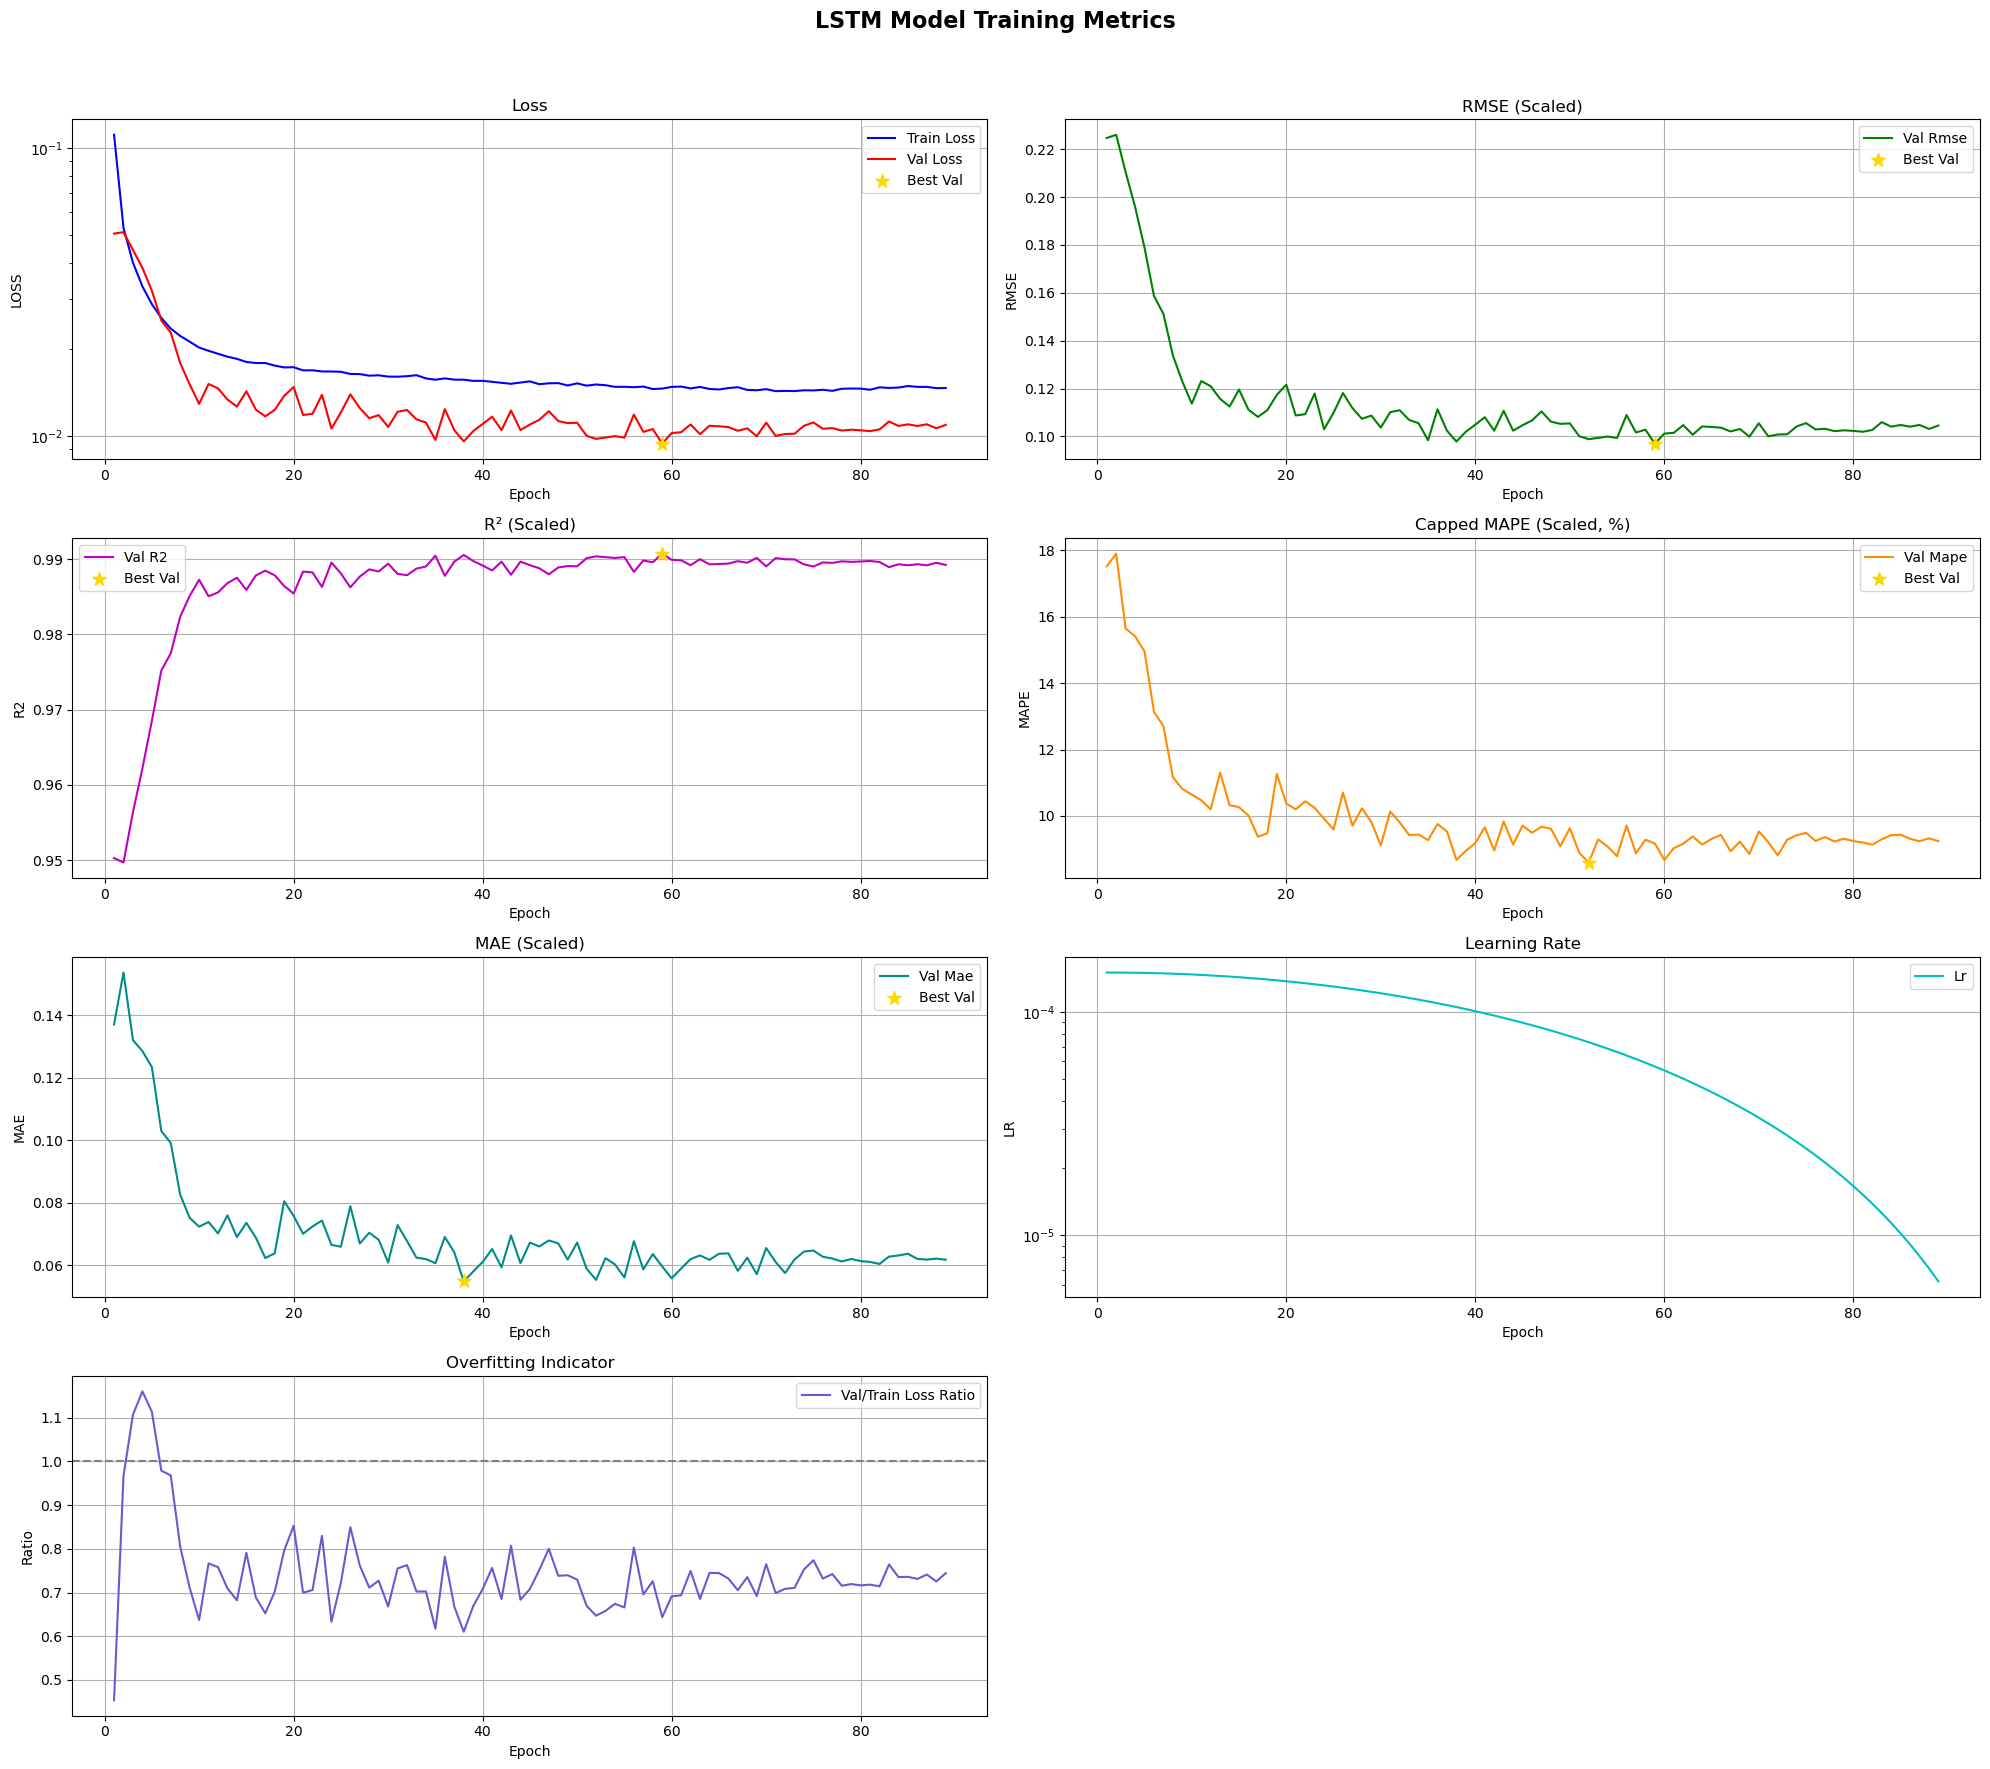

In [12]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = full_transform_details  # Store the whole transform_info object

2025-06-07 01:20:11,878 - INFO - Evaluating model on test data...
2025-06-07 01:20:16,609 - INFO - 
--- LSTM Scaled Metrics ---
2025-06-07 01:20:16,610 - INFO - RMSE (scaled): 0.1041, R² (scaled): 0.9893, MAE (scaled): 0.0602, Capped MAPE (scaled): 9.18%
2025-06-07 01:20:16,610 - INFO - 
--- LSTM Original Scale Metrics ---
2025-06-07 01:20:16,615 - INFO - RMSE (original): 0.1393, R² (original): 0.9893, MAE (original): 0.0806, Capped MAPE (original): 52.32%
2025-06-07 01:20:16,615 - INFO - Generating residual and prediction vs. actual plots for original scale data...


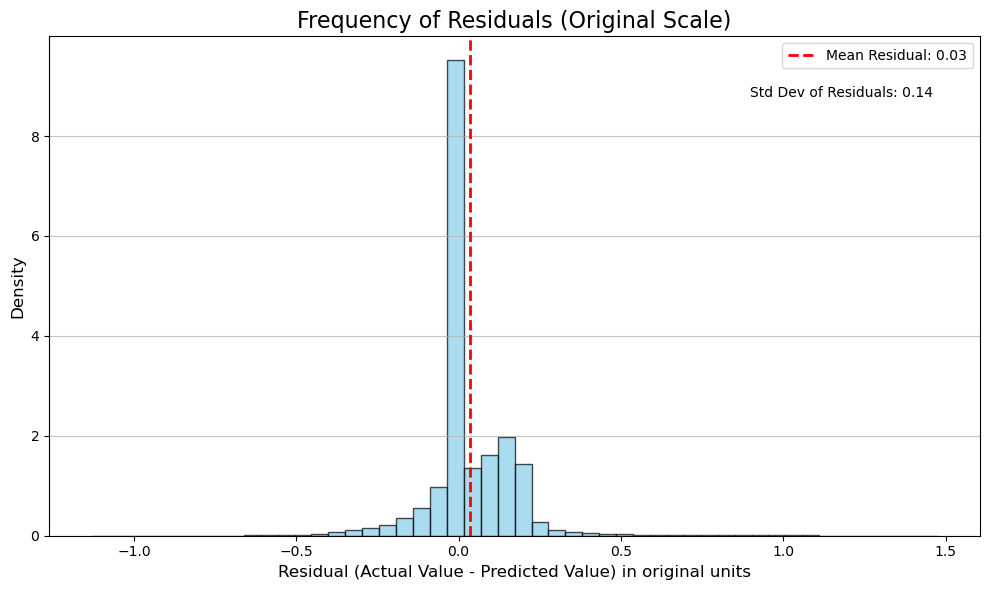

2025-06-07 01:20:16,849 - INFO - Sampled 10,000 points from 29513 for plotting


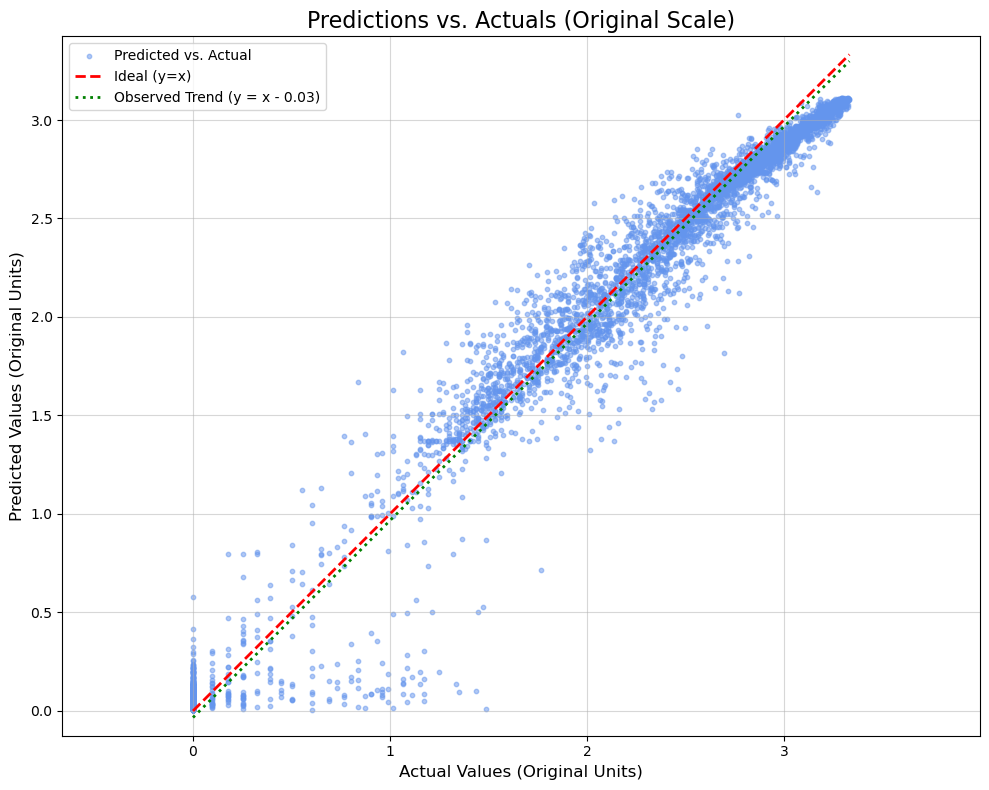

2025-06-07 01:20:16,984 - INFO - Test RMSE (original scale from metrics_dict): 0.1393
2025-06-07 01:20:16,984 - INFO - Test MAE (original scale from metrics_dict): 0.0806
2025-06-07 01:20:16,984 - INFO - Test Capped MAPE (original scale from metrics_dict): 52.32%
2025-06-07 01:20:16,985 - INFO - Test R² (original scale from metrics_dict): 0.9893
2025-06-07 01:20:16,985 - INFO - All scaled metrics: RMSE=0.1041, MAE=0.0602, Capped MAPE=9.18% R²=0.9893


In [13]:


logging.info("Evaluating model on test data...")
try:
    # Evaluate on test data using the refactored method signature
    scaled_preds, scaled_actuals, original_preds, original_actuals, metrics_dict = model.evaluate(
        X_test_data=X_test,
        y_test_data=y_test,
        device=device,  # Pass the device
        target_scaler_object=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info_dict=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers,  # Pass the whole scalers dictionary
        batch_size=32,
        return_predictions=True,
        plot_results=True
    )

    # Access metrics directly from the returned dictionary
    if original_preds is not None and original_actuals is not None:
        logging.info(f"Test RMSE (original scale from metrics_dict): {metrics_dict.get('rmse', 'N/A'):.4f}")
        logging.info(f"Test MAE (original scale from metrics_dict): {metrics_dict.get('mae', 'N/A'):.4f}")
        logging.info(f"Test Capped MAPE (original scale from metrics_dict): {metrics_dict.get('mape_capped', 'N/A'):.2f}%")
        logging.info(f"Test R² (original scale from metrics_dict): {metrics_dict.get('r2', 'N/A'):.4f}")
    else:
        logging.warning("Original scale predictions/actuals were not generated, cannot report original scale metrics here.")

    logging.info(f"All scaled metrics: "
                 f"RMSE={metrics_dict.get('scaled_rmse', 'N/A'):.4f}, "
                 f"MAE={metrics_dict.get('scaled_mae', 'N/A'):.4f}, "
                 f"Capped MAPE={metrics_dict.get('scaled_mape_capped', 'N/A'):.2f}% "
                 f"R²={metrics_dict.get('scaled_r2', 'N/A'):.4f}")

except Exception as e:
    logging.error(f"Error during model evaluation: {e}", exc_info=True)




2025-06-07 01:20:16,992 - INFO - Generating residual and prediction vs. actual plots for original scale data...


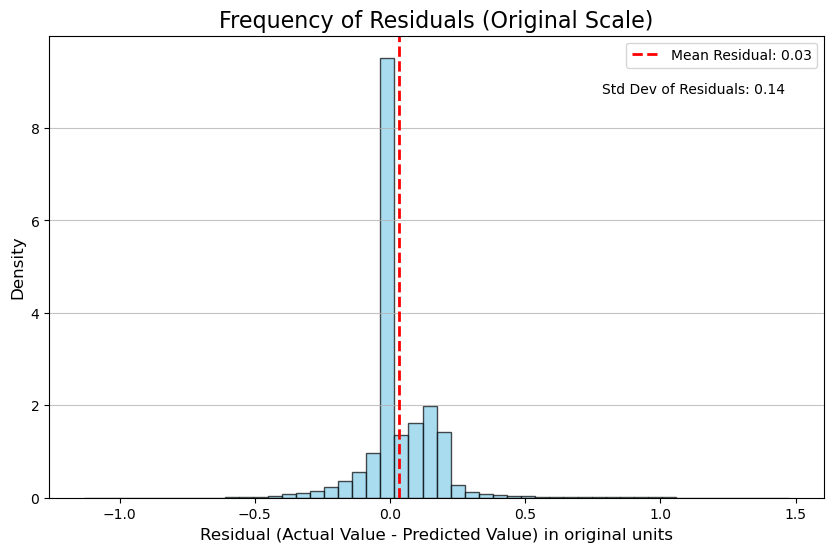

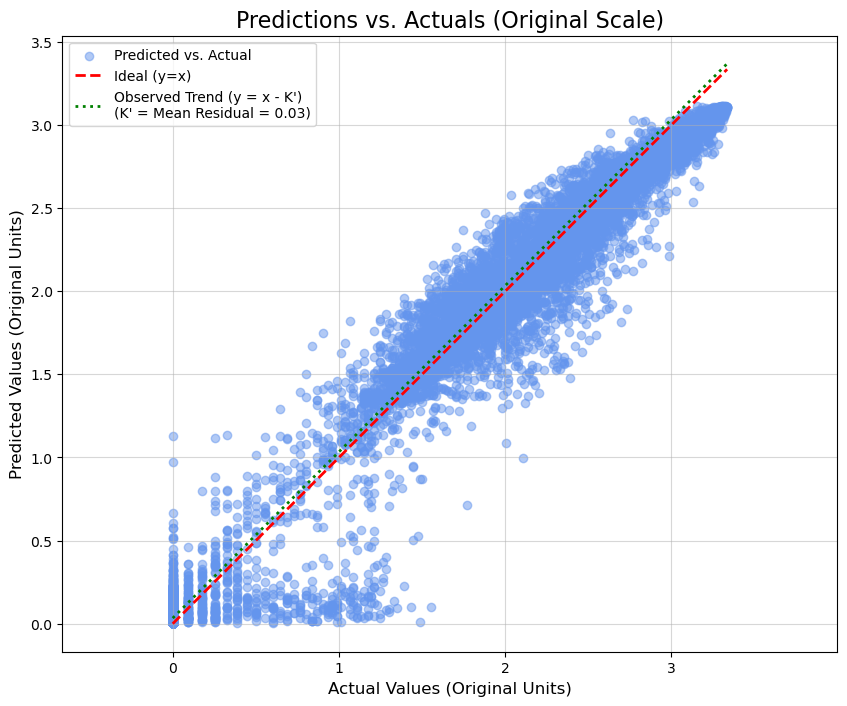

In [14]:
if original_actuals is not None and original_preds is not None:
    logging.info("Generating residual and prediction vs. actual plots for original scale data...")
    
    # Calculate residuals in the original scale
    residuals_original = original_actuals.flatten() - original_preds.flatten()
    mean_residuals_original = np.mean(residuals_original)
    std_residuals_original = np.std(residuals_original)

    # --- 1. Frequency of Residuals (Histogram) in Original Scale ---
    plt.figure(figsize=(10, 6))
    plt.hist(residuals_original, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    plt.axvline(mean_residuals_original, color='red', linestyle='dashed', linewidth=2, 
                label=f'Mean Residual: {mean_residuals_original:.2f}')
    plt.title('Frequency of Residuals (Original Scale)', fontsize=16)
    plt.xlabel(f'Residual (Actual Value - Predicted Value) in original units', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.75)
    plt.text(0.95, 0.90, f'Std Dev of Residuals: {std_residuals_original:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.show()

    # --- 2. Predictions vs. Actuals in Original Scale ---
    plt.figure(figsize=(10, 8))
    plt.scatter(original_actuals, original_preds, alpha=0.5, color='cornflowerblue', label='Predicted vs. Actual')
    
    # Determine plot limits for y=x line and observed trend
    min_val = min(np.min(original_actuals), np.min(original_preds))
    max_val = max(np.max(original_actuals), np.max(original_preds))
    
    # Ideal line (y=x)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')
    
    # Observed trend line (y = x - K', where K' is mean_residuals_original)
    # This line represents: predicted = actual - mean_residual
    plt.plot([min_val, max_val], 
             [min_val + mean_residuals_original, max_val + mean_residuals_original], 
             # Corrected: if residual = actual - predicted, then predicted = actual - residual.
             # So if K' = actual - predicted, then predicted = actual - K'.
             # The plot should be y (predicted) vs x (actual).
             # If mean_residuals_original > 0, model under-predicts on average, so predicted = actual - |K'|
             # If mean_residuals_original < 0, model over-predicts on average, so predicted = actual + |K'|
             # So, it's always predicted = actual - mean_residuals_original
             'g:', lw=2, 
             label=f'Observed Trend (y = x - K\')\n(K\' = Mean Residual = {mean_residuals_original:.2f})')
             
    plt.title('Predictions vs. Actuals (Original Scale)', fontsize=16)
    plt.xlabel('Actual Values (Original Units)', fontsize=12)
    plt.ylabel('Predicted Values (Original Units)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.5)
    plt.axis('equal') 
    plt.show()

else:
    logging.warning("Could not generate plots because original_actuals or original_preds is None.")

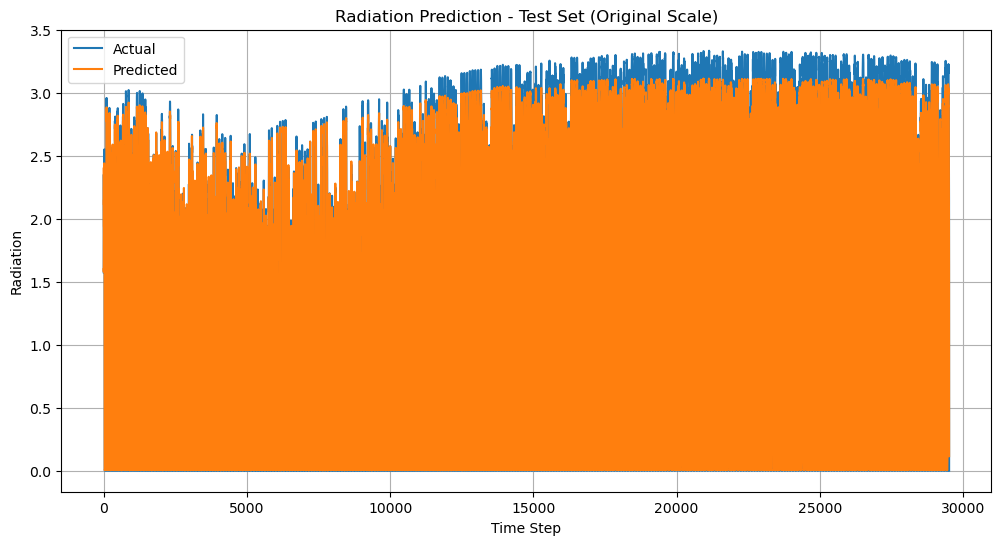

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals, label='Actual')
plt.plot(original_preds, label='Predicted')
plt.title('Radiation Prediction - Test Set (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df["GHI"].max()

229.2

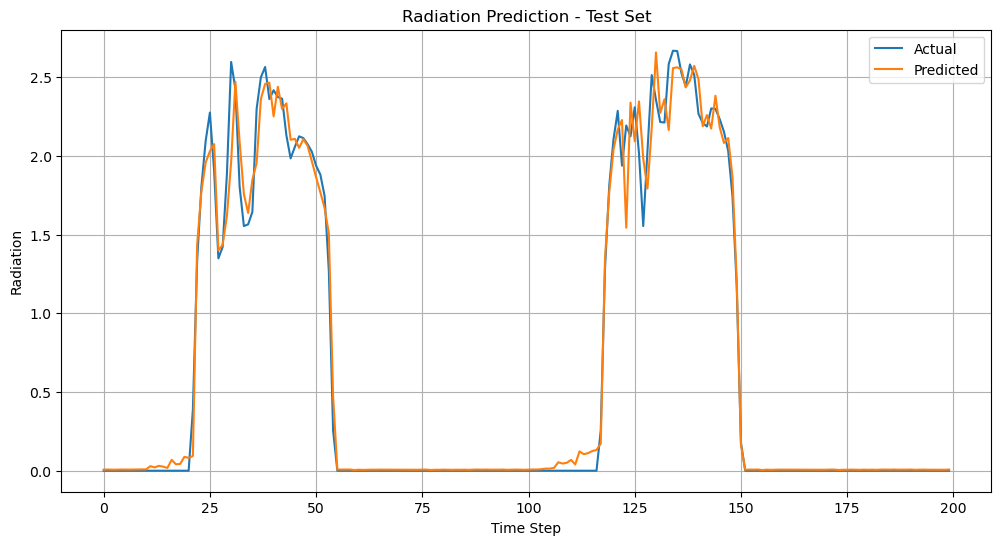

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals[2950:3150], label='Actual')
plt.plot(original_preds[2950:3150], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
pred_with_uncertainty = model.predict_with_uncertainty(X_test[0:100], mc_samples=30,        
        target_scaler=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers,
        device = device)  # Pass the whole scalers dictionary)

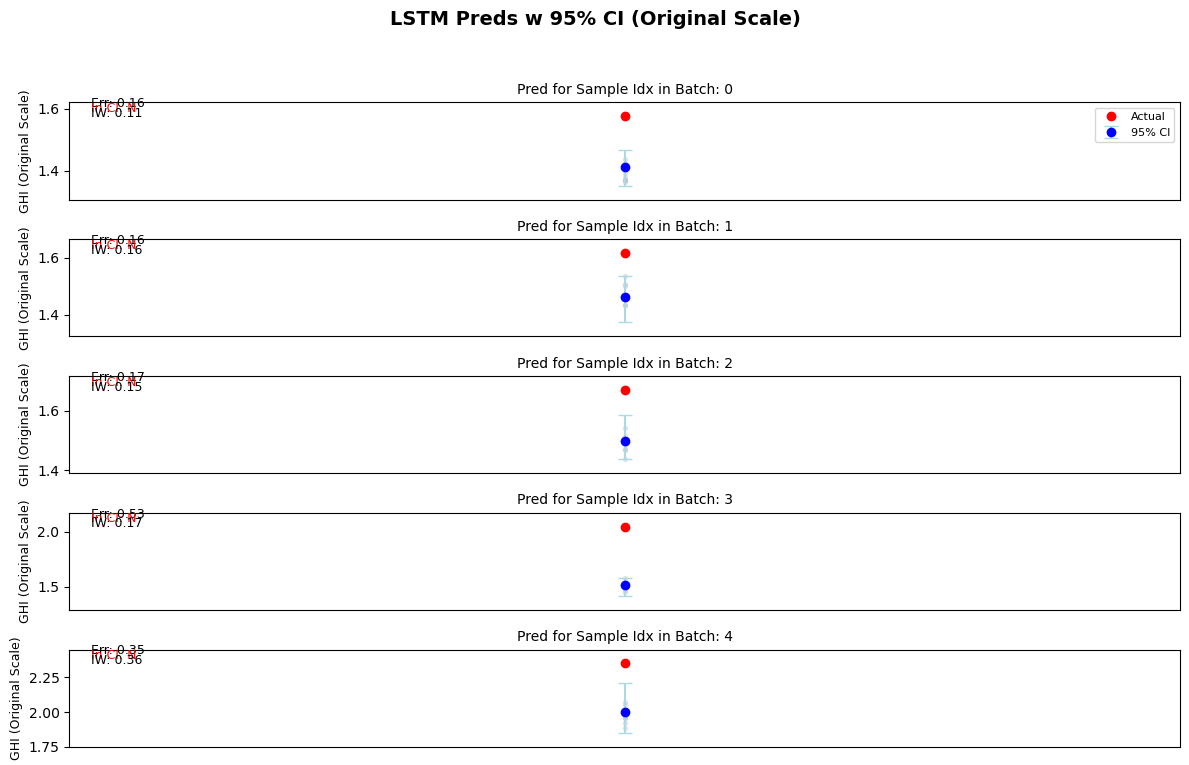

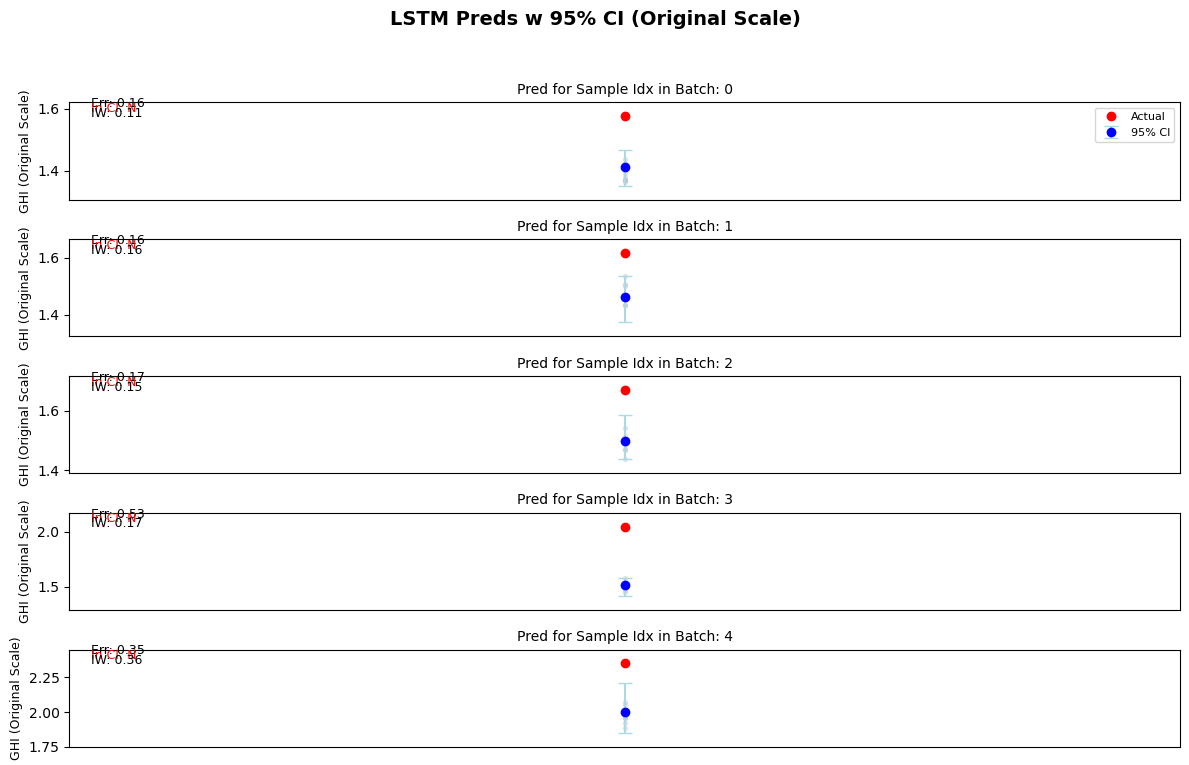

In [19]:
model.plot_prediction_with_uncertainty(X_test[0:100],y_test[0:100],mc_samples=30, 
                                       target_scaler=scalers.get(full_transform_details.get('target_scaler_name')),
                                       transform_info=full_transform_details, # This should be the output from data_prep
                                        scalers_dict=scalers,
                                        device = device,
                                        max_samples_to_plot = 5)


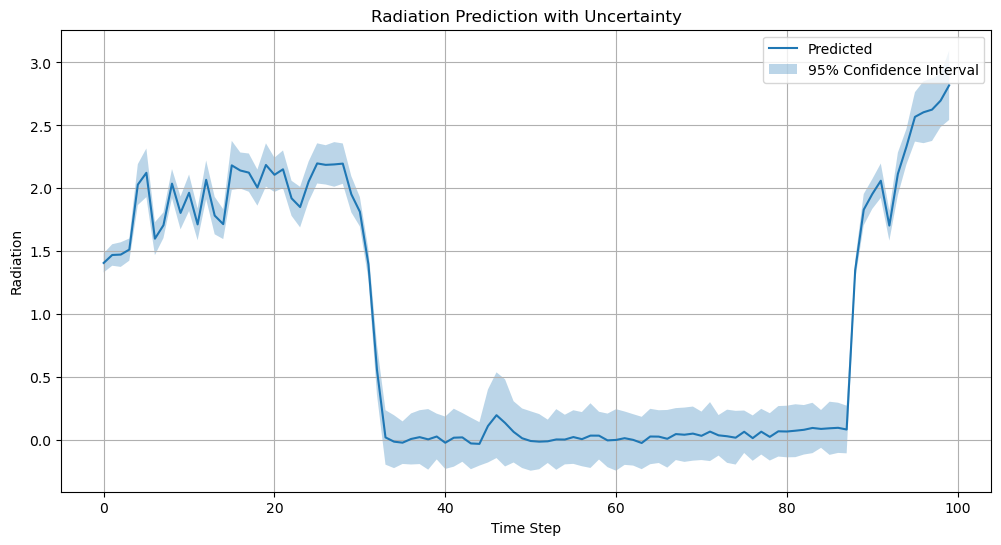

In [20]:
# plot uncertainty
plt.figure(figsize=(12, 6))
plt.plot(pred_with_uncertainty['mean'].squeeze(), label='Predicted')
plt.fill_between(range(len(pred_with_uncertainty['std'])), 
                 (pred_with_uncertainty['mean'] - 1.96 * pred_with_uncertainty['std']).squeeze(),
                 (pred_with_uncertainty['mean'] + 1.96 * pred_with_uncertainty['std']).squeeze(),
                 alpha=0.3, label='95% Confidence Interval')
plt.title('Radiation Prediction with Uncertainty')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(model.fc3.bias.item())
print(model.fc3.weight)


0.0638284683227539
Parameter containing:
tensor([[-0.0635, -0.0780,  0.0428, -0.0879, -0.0963, -0.1051, -0.0744, -0.0839,
         -0.0946,  0.0645,  0.1229,  0.0517, -0.1085, -0.0535, -0.0889,  0.0521,
          0.0768, -0.0848, -0.0469,  0.0231,  0.0961,  0.1090,  0.0338,  0.1270,
         -0.0795,  0.0308, -0.0872,  0.0447,  0.0449,  0.0440, -0.0785,  0.0491,
          0.0457, -0.0642, -0.0718, -0.0827, -0.0931,  0.0555,  0.0866, -0.0694,
          0.0891,  0.1264, -0.0465, -0.0842, -0.0696, -0.1075,  0.0872,  0.0550,
          0.0520,  0.1134,  0.0542, -0.0990,  0.0946,  0.0238, -0.0872,  0.0445,
          0.0345,  0.0379,  0.0429,  0.0402, -0.0988, -0.0864, -0.0857, -0.0910,
          0.0434,  0.0359, -0.0561, -0.0726,  0.0404, -0.0964, -0.0747, -0.0966,
          0.2385, -0.1154, -0.0703,  0.0352, -0.0639, -0.0599, -0.0950, -0.0437,
         -0.0772, -0.0836, -0.0818,  0.0547,  0.0380,  0.0716,  0.0589, -0.0686,
         -0.0790,  0.0364, -0.0460,  0.0389,  0.0474, -0.0820,  0.03

In [22]:
model.save('weather_lstm_model.pt')

2025-06-07 01:20:20,495 - INFO - LSTM Model saved to weather_lstm_model.pt
